In [25]:
%run featimp

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from matplotlib import colors 
import matplotlib.font_manager
%config InlineBackend.figure_format = 'retina'

# Exploring Feature Importance Strategies and Their Impact on Model Performance

+ Importance strategies working directly from the data
    - Spearman's rank coefficient
    - PCA
+ Model-based importance strategies
    - Drop-column importance
    - Permutation importance
+ Comparing strategies
    - Given a model, does different methods of selecting features perform similarly? 
    - Given a fixed feature importance, does it perform similarly on different models?
+ Automatic feature selection algorithm
+ Variance and empirical p-values for feature importances
    - Visualize feature importance with error bars
    - Feature selection with null importances

# 1. Importance strategies working directly from the data

## 1.1 Spearman's rank coefficient

### 1.1.1 Explanation

Spearman's rank coefficient is the simplest technique to identify the importance of features. It is the nonparametric version of the Pearson correlation coefficient. To compute the Spearman's rank coefficient between two variables, first convert each variable to its rank values, and then running a standard Pearson's correlation on those ranked variables. The mathematical formula can be written as:

$r = \frac{cov(rk_{X}, rk_{Y})}{\sigma(rk_{X})\sigma(rk_{Y})} $

where $rk_{X}$ means the rank variables derived by variable X.

Some limitations of Spearman's rank coefficient are:
+ It measures single-feature importance, it works well for independent features, but does not do a good job for codependent features.
+ If two features have similar relationships with the target variable, their rank variables will be similar too. However, maybe only one of them should be considered important.
+ It doesn't work well for categorical variables.

### 1.1.1 Example

In [121]:
df = pd.read_csv("data/rent-numeric.csv")
df.head(2)

,bathrooms,bedrooms,price,longitude,latitude,interest_level
0,1.5,3,3000,-73.9425,40.7145,2
1,1.0,2,5465,-73.9667,40.7947,1


We use interest_level as the target variable and the rest as features, examine the Spearman's rank coefficient between the target and each feature.  
The data is preprocessed using reference: https://mlbook.explained.ai/first-taste.html#sec:3.2

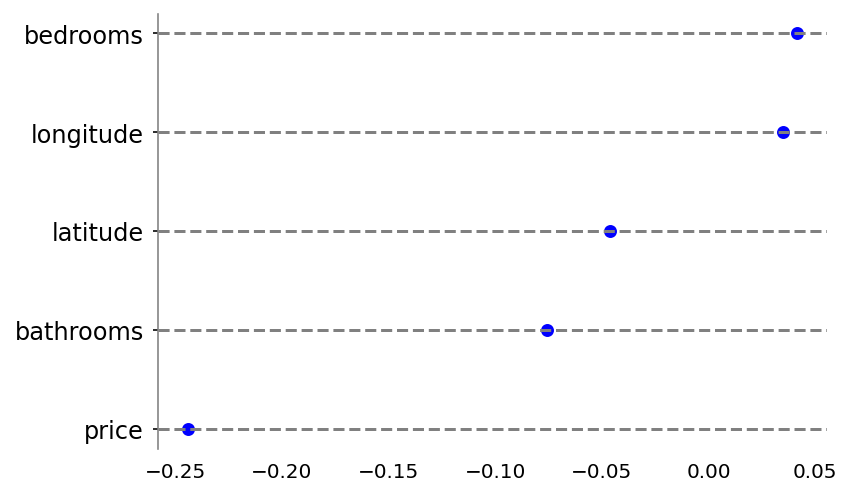

In [122]:
# split features and target variable
features = df.columns.tolist()
features.remove('interest_level')

coeff = spearman_coeff(df, features, 'interest_level')
visualize_importances(coeff);

The feature with the largest Spearman's rank coefficient with target variable is identified to be the most important. In this case, bedrooms is the most important feature.

## 1.2 principal component analysis (PCA)
### 1.2.1 Explanation
Another approach to identify importance directly from the data is to perform principle component analysis. The idea is to reduce the dimension of dataset while preserving as much information as possible. It is executed by the following steps:
+ 1. Standardization  
This is to make sure each of the features are transformed to the same scale and thus contributes equally to the analysis.
+ 2. Compute covariance matrix  
This is to see the relationship between all pairs of possible variables.
+ 3. Identify principal components  
Principal components is identified by compute eigenvectors and eigenvalues of the covariance matrix. A basic explanation for principal components: if the original data is n-dimensional, there will be n principal components. These principal components are uncorrelated, and it is done in such a way that most of the information within the original data will be compressed into the first component, then maximum remaining information in the second and so on, the n-th component will be the one has the least remaining information.
+ 4. Identify feature vector  
Order the principal components by significance, keep the first p components and discard the rest of them which is of lesser significance. Here p is defined by human.
+ 5. Recast the original data  
Use feature vector to reorient the data to the axes represented by the principal components. 

### 1.2.2 Example


In [123]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])
iris.head(3)

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa


In [124]:
# split features and target variable
features = iris.columns.tolist()
features.remove('target')
X = iris[features]
y = iris['target']

# Standardizing the features
X = StandardScaler().fit_transform(X)

# PCA Projection to 2-dimensional
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(X)
recasted_X = pd.DataFrame(data = principal_comp
             , columns = ['principal_comp_1', 'principal_comp_2'])
recasted_X.head(3)

,principal_comp_1,principal_comp_2
0,-2.264542,0.505704
1,-2.086426,-0.655405
2,-2.367950,-0.318477


In [125]:
# Concatenating the recasted data and target variable
final_df = pd.concat([recasted_X, y], axis = 1)
final_df.head(3)

,principal_comp_1,principal_comp_2,target
0,-2.264542,0.505704,Iris-setosa
1,-2.086426,-0.655405,Iris-setosa
2,-2.367950,-0.318477,Iris-setosa


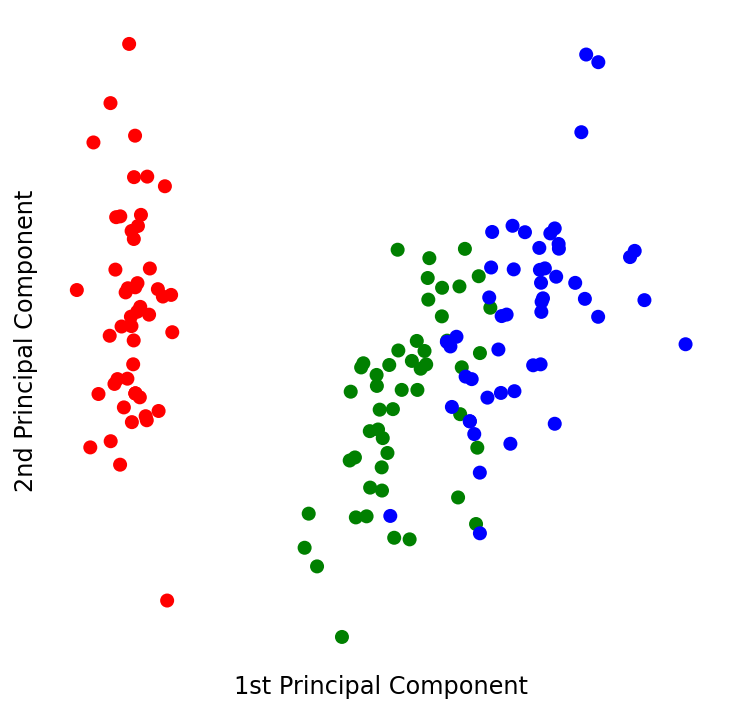

In [126]:
# Visualize 2D Projection
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel('1st Principal Component', fontsize = 12)
ax.set_ylabel('2nd Principal Component', fontsize = 12)

target2color = {'Iris-setosa':'r', 'Iris-versicolor': 'g', 'Iris-virginica': 'b'}
ax.scatter(x=final_df['principal_comp_1'], 
           y=final_df['principal_comp_2'], 
           c=final_df['target'].map(target2color));

# hide the spines
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# hide the ticks
ax.axes.xaxis.set_ticks([]);
ax.axes.yaxis.set_ticks([]);

As shown above, I performed PCA to reduce the dimension of the data from 4 to 2. Even though the dimension is reduced, the two principal component keeps the most of the information so we are able to see from the graph that the three classes are well separated from each other.

# 2. Model-based importance strategies


Having talked about importance strategies working directly from the data, let's move to model-based importance strategies. Two of the very useful strategies are drop-column importance and permutation importance.  
Reference: https://github.com/parrt/random-forest-importances

## 2.1 Drop-column importance

### 2.1.1 Explanation
A brute force mechanism is to loop through all features and examine the importance of each feature. The process of finding the drop-column importance of feature $x_{k}$ is as follows:
+ Train the model on all features and compute the validation metric, this metric will be the baseline.
+ Drop column $x_{k}$ from the training set
+ Re-train the model with the same parameters and compute the validation metric
+ Importance score of feature $x_{k}$ is the change in the metric

### 2.1.2 Example

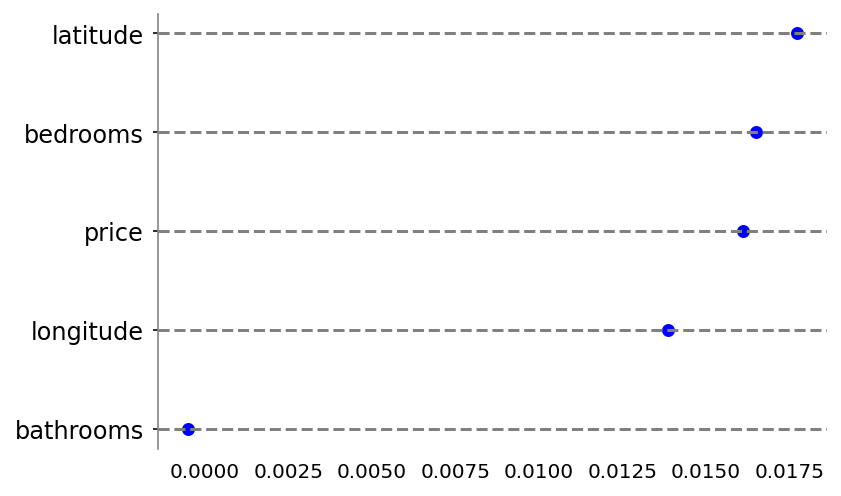

In [442]:
# preprocessed data reference: https://mlbook.explained.ai/first-taste.html#sec:3.2
df = pd.read_csv("data/rent-numeric.csv")

# split features and target variable
features = df.columns.tolist()
features.remove('interest_level')
X = df[features]
y = df['interest_level'].values

# split the data into train and val
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

# setup a baseline model
clf = RandomForestClassifier()

# compute feature importance 
score = accuracy_score
feature_imp = dropcol_importances(clf, X_train, y_train, X_valid, y_valid, score)
visualize_importances(feature_imp);

For this example, using default RandomForestClassifier as the baseline model, drop-column importance assumes bedrooms is the most important features.

### 2.1.3 Pros/Cons of drop-column importance
+ It works for any machine learning model.
+ It is very expensive. If there are n features, it needs to retrain the model p times. 
+ It doesn't work well for codependent features as they often result in getting zero or very low importance. 

## 2.2 Permutation importance

### 2.2.1 Explanation
Permutation importance is similar to drop-column importance, but instead of simply dropping the feature from the model, it keeps the feature but breaks its relationships with the target variable. The process of finding the permutation importance of feature $x_{k}$ is as follows:
+ Train the model on all features and compute the validation metric, this metric will be the baseline.
+ Permute column $x_{k}$ in the validation set and compute the validation metric
+ Importance score of feature $x_{k}$ is the change in the metric

### 2.2.2 Example

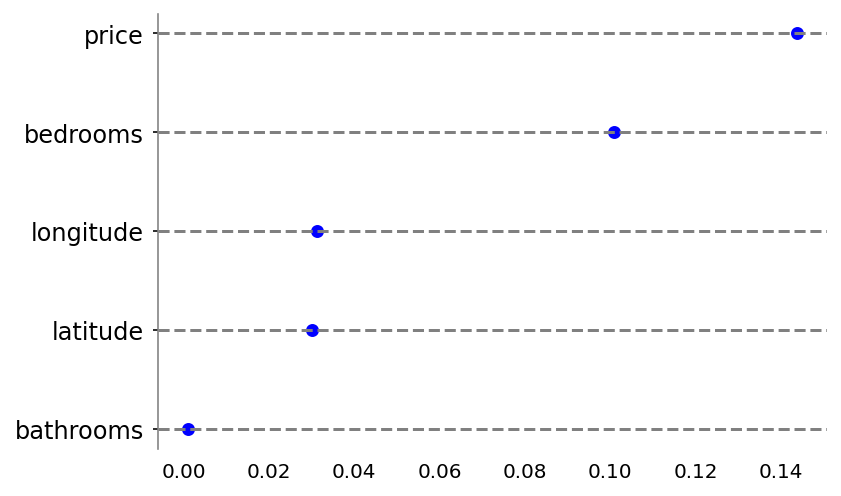

In [443]:
# split features and target variable
features = df.columns.tolist()
features.remove('interest_level')
X = df[features]
y = df['interest_level'].values

# split the data into train and val
X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2)

# fit a baseline model
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# compute feature importance 
score = accuracy_score
feature_imp = permutation_importances(clf, X_val, y_val, score)
visualize_importances(feature_imp);

For this example, using default RandomForestClassifier as the baseline model, permutation importance assumes price is the most important features.

### 2.2.3 Pros/Cons of permutation importance
+ It works for any machine learning model.
+ It is more efficient than drop-column importance, because it doesn't need to retrain the model. 
+ Codependent features often share permutation importance. 
+ It may create nonsensical records through permutation.

# 3. Comparing strategies

Now let's move to stratrgies comparison. The idea is to use different methods(Spearman's rank coefficient, PCA, Linear regression) to compute feature importance. Then, for each of the feature importance, train the model on the top k=1..p features to see how good those features are. 

First, let's load the bulldozer datastet, specify the features and target variable, and perform standardization for X.   
The data is preprocessed using reference: https://mlbook.explained.ai/bulldozer-intro.html#sec:7.4

In [ ]:
# data preprocessing
# dataset reference: https://mlbook.explained.ai/bulldozer-intro.html#sec:7.4
df = pd.read_feather("data/bulldozer-train-processed.feather")

# split features and target variable
features = ['YearMade', 'fiProductClassSpec_lower', 'ProductSize', 
            'Hydraulics_Flow_Standard', 'fiProductClassDesc', 'fiProductClassSpec_upper',
            'Enclosure_EROPS AC', 'fiModelDescriptor', 'ModelID']
target = 'SalePrice'

# standardize x 
x = df[features].values
x_scaled = StandardScaler().fit_transform(x)
df_scaled = pd.DataFrame(x_scaled, columns=features)

# concatenate with target variable
df_scaled[target] = df[target]

Let's use Spearman's rank coefficient to get feature importance.

In [307]:
# compute Spearman's rank coefficient
sp_coeff = spearman_coeff(df_scaled, features, target)

# sorted the importance in descending order
sorted_importances = dict(sorted(sp_coeff.items(), key=lambda item: item[1], reverse=True))
sorted_importances

{'Enclosure_EROPS AC': 0.5690759661927002,
 'ProductSize': 0.44383789782282823,
 'fiModelDescriptor': 0.36851547782786476,
 'YearMade': 0.21833533496695828,
 'fiProductClassDesc': 0.11998049414708963,
 'fiProductClassSpec_lower': 0.034857928445302576,
 'fiProductClassSpec_upper': 0.017176918614242313,
 'ModelID': -0.13628688603781305,
 'Hydraulics_Flow_Standard': -0.47695603426444244}

Spearman's rank coefficient assumes *Enclosure_EROPS AC* is the most important feature. Now let's move to train the RandomForestRegressor on the top k=1..p features and see the model performance, i.e, when k = 1, train the model only using *Enclosure_EROPS AC* columns as feature, perform 5-fold cross valiadation and compute mean absolute error on the test set; when k=2, train the model using *Enclosure_EROPS AC, ProductSize* as features.

In [381]:
model = RandomForestRegressor()
y = df_scaled[target].values
k_score_sp = model_w_top_k_features(df=df_scaled, y=y, 
                                 sorted_importances=sorted_importances, 
                                 model=model, max_k=8)
k_score_sp

{1: 14224.282044730722,
 2: 12811.200836340779,
 3: 12026.395780709401,
 4: 9947.256848560206,
 5: 7378.286893763191,
 6: 6560.754582009451,
 7: 6532.156706906011,
 8: 5164.856619082465}

k_score_sp is a dictionary with k-value being the keys and validation score being the values. For the first item in k_score_sp, it means that when training the model using the top 1 feature, the 5-fold cross-validation MAE on the test set is over 14000($). 

Next, use PCA to get feature importance, and train the RandomForestRegressor on the top k=1..p features to get another dictionary.

In [ ]:
X = df_scaled[features].values
y = df_scaled[target].values

model = RandomForestRegressor()
k_score_pca = model_w_pca(X, y, model, max_k=8)

In the same way, use OLS to get feature importance, and train the RandomForestRegressor on the top k=1..p features to see the model performance.

In [312]:
# fit the OLS model 
model = LinearRegression()
model.fit(X, y)

# get importance
importance = model.coef_

# sort importance 
ols_importance = {}
for i, feature in enumerate(features):
    ols_importance[feature] = importance[i]    
sorted_ols_importance = dict(sorted(ols_importance.items(), key=lambda item: item[1], reverse=True))

# train model on the top k=1..p features  
model = RandomForestRegressor()
k_score_ols = model_w_top_k_features(df=df_scaled, y=y, 
                       sorted_importances=sorted_ols_importance, 
                       model=model, max_k=8)

To make a comparison, let's visualize the model performance. We can see obviously that PCA does a better job on reducing dimensionality and deciding which features are most important, and therefore the model trained on features that are selected by PCA has lower validation error.

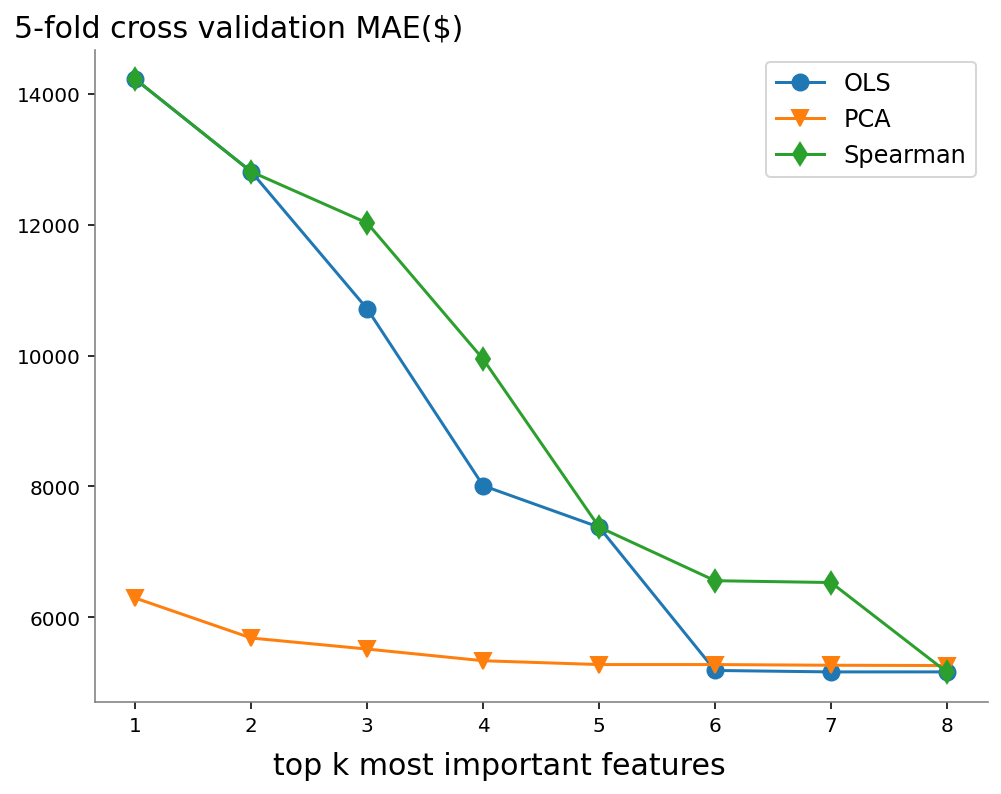

In [380]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(list(k_score_ols.keys()), list(k_score_ols.values()), 
        '-o', markersize=8, label='OLS');
ax.plot(list(k_score_pca.keys()), list(k_score_pca.values()), 
        '-v', markersize=8, label='PCA');
ax.plot(list(k_score_sp.keys()), list(k_score_sp.values()), 
        '-d', markersize=8, label='Spearman');

ax.text(0.2, -0.11, 'top k most important features', fontsize=15, transform=ax.transAxes);
ax.text(-0.09, 1.02, '5-fold cross validation MAE($)', fontsize=15, transform=ax.transAxes);

# hide the spines
ax.spines['left'].set_color('gray')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('gray')

ax.legend(fontsize=12);

Notice that we are using the same model, but different strategies to pick the most important features. Another comparison we are interested in is that given a fixed feature ranking, we train different models on the top k=1..p features to see how good those features are.  
Let's use the recommended features determined by Spearman's rank coefficient to test with OLS, RF, and XGBoost.

In [398]:
rf_model = RandomForestRegressor()
ols_model = LinearRegression()
xgb_model = XGBRegressor()
candidate_models = [rf_model, ols_model, xgb_model]

candidate_performance = []
for model in candidate_models:
    performance = model_w_top_k_features(df=df_scaled, y=y, 
                           sorted_importances=sorted_importances, 
                           model=model, max_k=8)
    candidate_performance.append(performance)

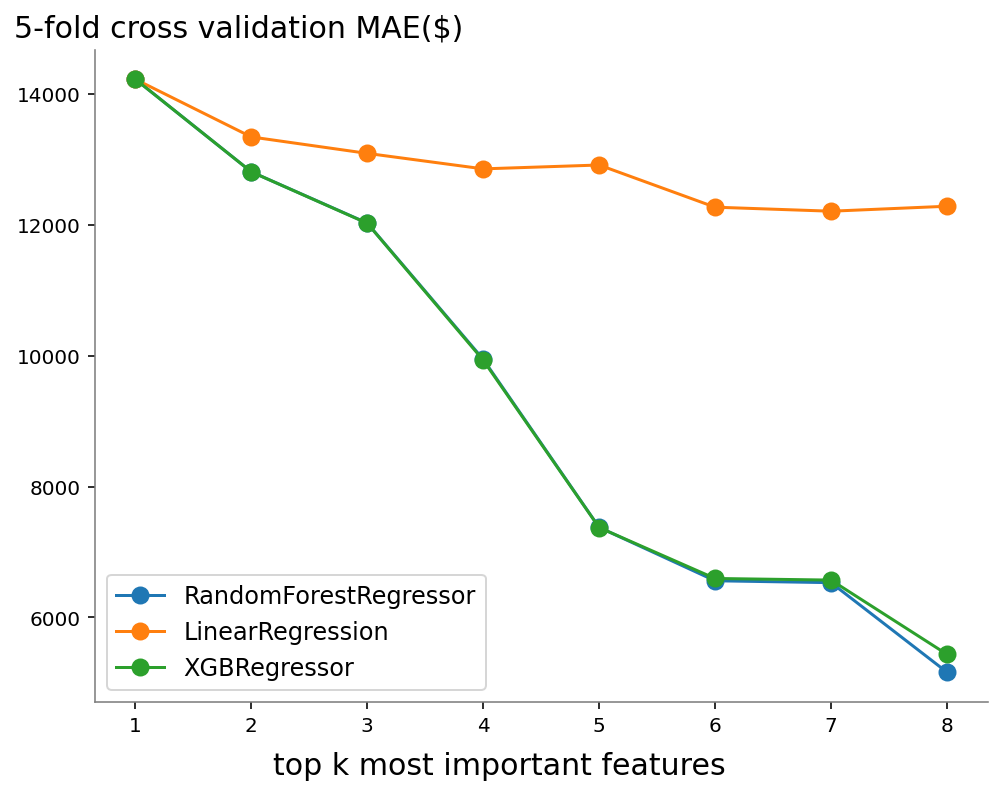

In [399]:
fig, ax = plt.subplots(figsize=(8, 6))

for model, performance in zip(candidate_models, candidate_performance):
    ax.plot(list(performance.keys()), list(performance.values()), 
            '-o', markersize=8, label=model.__class__.__name__);

ax.text(0.2, -0.11, 'top k most important features', fontsize=15, transform=ax.transAxes);
ax.text(-0.09, 1.02, '5-fold cross validation MAE($)', fontsize=15, transform=ax.transAxes);

# hide the spines
ax.spines['left'].set_color('gray')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('gray')

ax.legend(fontsize=12);

From the graph we can see, using the recommended features by Spearman's rank coefficient, the performance of linear regression is different from random forest and xgboost, it’s clear that the quality for a given feature ranking varies from model to model.

# 4. Automatic feature selection algorithm

In this section, I performed an automatic feature selection algorithm. Given the original list of features and the target variable, the goal of this algorithm is to automatically drop unimportant features and keep the top k features, where k is not predefined and is determined automatically by the algorithm.
The step of the algorithm is:
1. Choose the model you will use and the metric for evaluating the model performance.
2. Split the dataset into a training set and a validation set. 
3. Use the original features and target variable to train the model, and get a baseline validation metric.
4. Compute feature importance by Spearman rank correlation coefficient and drop the lowest importance feature
5. Retrain the model and calculate the validation metric.
    - If the validation metric is lower than the baseline validation metric, we stop dropping and add the lowest importance feature back to the features list, and then this is the list of final features.
    - If the validation metric is higher than the baseline validation metric, repeat steps 4 and 5. 


In [500]:
# data preprocessing
# dataset reference: https://mlbook.explained.ai/bulldozer-intro.html#sec:7.4
df = pd.read_feather("data/bulldozer-train-processed.feather")

# split features and target variable
features = ['YearMade', 'fiProductClassSpec_lower', 'ProductSize', 
            'Hydraulics_Flow_Standard', 'fiProductClassDesc', 'fiProductClassSpec_upper',
            'Enclosure_EROPS AC', 'fiModelDescriptor', 'ModelID']
target = 'SalePrice'

# standardize x 
x = df[features].values
x_scaled = StandardScaler().fit_transform(x)
df_scaled = pd.DataFrame(x_scaled, columns=features)

# concatenate with target variable
df_scaled[target] = df[target]

# rename the dataframe
df = df_scaled.copy()

In [502]:
# choose the model and metric
model = RandomForestRegressor()
score = r2_score

# run automatic feature selection
final_features = automatic_feature_selection(model, df, features, target, score)

Baseline validation metric: 0.8754474282791032

k=9
Drop the lowest importance feature:  Hydraulics_Flow_Standard
The validation metric of re-trained model: 0.875485760978729

k=8
Drop the lowest importance feature:  ModelID
The validation metric of re-trained model: 0.8114200627320642
The validation metric is worse, stop dropping.

numbr of features selected: 8


This algorithm prints out some information while it is running. We are able to see which feature improves the model performance and which is decreased. After it finishes, it will return the final list of features. 

# 5. Variance and empirical p-values for feature importances


## 5.1 Visualize feature importance with error bars

In this section, I use bootstrapping method to resample the normalized dataset, and then for each resampled dataset, use permutation feature importance to compute feature importance. In this way, I have multiple values of importance for each feature. Then compute the mean and standard deviation for feature importance. Plot the mean of importance together with error bars that represent two standard deviations.

In [617]:
# preprocessed data reference: https://mlbook.explained.ai/first-taste.html#sec:3.2
df = pd.read_csv("data/rent-numeric.csv")

# split features and target variable
features = df.columns.tolist()
features.remove('interest_level')
target = 'interest_level'

# standardize x 
x = df[features].values
x_scaled = StandardScaler().fit_transform(x)
df_scaled = pd.DataFrame(x_scaled, columns=features)

# concatenate with target variable
df_scaled[target] = df[target]

# rename the dataframe
df = df_scaled.copy()

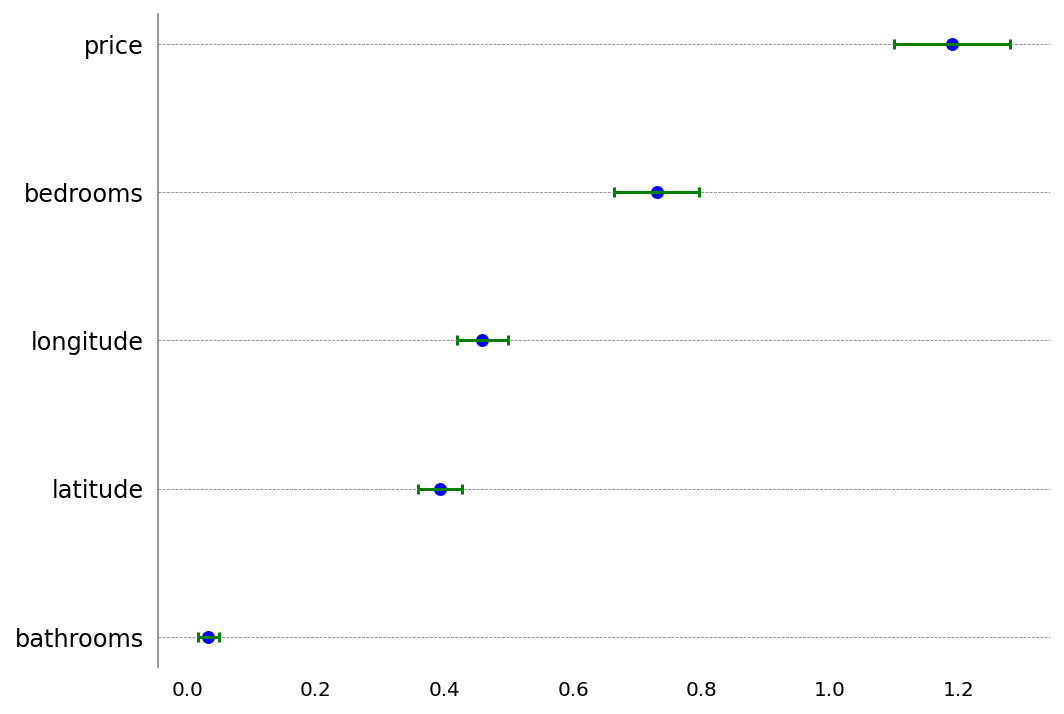

In [618]:
# choose the model and metric
model = RandomForestRegressor()
score = r2_score

# choose times to do boostrapping
n = 50

importances_w_errorbars(df, n, features, target, model, score)

From above we can see, for this rent dataset, price is the most important feature, but its variance is also the largest.

## 5.2 feature selection with null importances
In this section, I use p-values to decide if a feature's important is significant. For comparison purpose, we need a null distribution. The steps for implementing this are as follows:
1. Use the original dataset to compute the true feature importance of ${x_j}$ as a baseline. 
2. Shuffle the target variable y, and then compute the feature importance of ${x_j}$  again.
3. Run the simulation multiple times(here I choose 100) to get a null distribution. 

Count the number of times the simulated importance is as important or more important than the baseline, which means simulated importance is equal to or greater than the baseline importance. If the percentage is great than 5%, then the importance of feature ${x_j}$ is not significant, thus we can say ${x_j}$ is not important.

reference: https://www.kaggle.com/ogrellier/feature-selection-with-null-importances

In [16]:
# preprocessed data reference: https://mlbook.explained.ai/first-taste.html#sec:3.2
df = pd.read_csv("data/rent-numeric.csv")

# split features and target variable
features = df.columns.tolist()
target = 'interest_level'
features.remove(target)

# standardize x 
x = df[features].values
x_scaled = StandardScaler().fit_transform(x)
df_scaled = pd.DataFrame(x_scaled, columns=features)

# concatenate with target variable
df_scaled[target] = df[target]

# rename the dataframe
df = df_scaled.copy()

# split features and target variable again
X = df[features]
y = df[target].values

Let's first compute feature importance using permutation importances method.

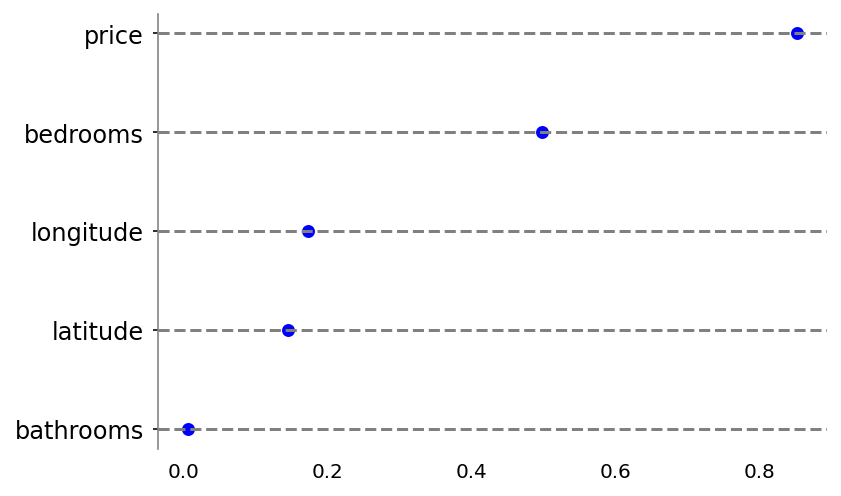

In [15]:
# split the data into train and val
X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2)

# fit a baseline model
clf = RandomForestRegressor()
clf.fit(X_train, y_train)

# compute feature importance 
score = r2_score
feature_imp = permutation_importances(clf, X_val, y_val, score)
visualize_importances(feature_imp);

We can see that *price* is the most important feature. Let's use p-values to test if its importance is significant.

In [18]:
# examine the significance of price's importance
col = 'price'
n = 100
model = RandomForestRegressor()
imps, baseline_imp = importance_w_empirical_p(X, y, col, model, score, n)
print(f'p value is {np.sum(imps > baseline_imp) / len(imps)}')

p value is 0.0


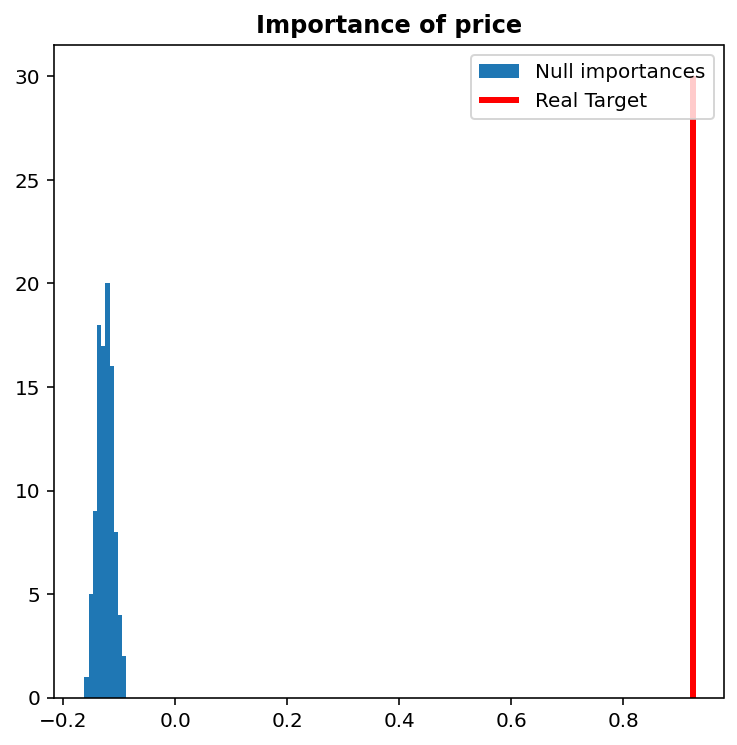

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(imps, label='Null importances')
ax.vlines(baseline_imp, ymin=0, ymax=30, color='r', 
              linewidth=3, label='Real Target')
ax.legend()
ax.set_title(f'Importance of {col}', fontweight='bold');

p value = 0.0 < 0.05, we can also see from the plot that the true importance is far away from null distribution, which means that the importance of feature *price* is significant.So we can say *price* is indeed an important feature.  
Now let's move to examine the significance of *bedrooms*'s importance. *Bedrooms* is the second important features by the permutation importances.

In [21]:
# examine the significance of bedrooms's importance
col = 'bedrooms'
n = 100
model = RandomForestRegressor()
imps, baseline_imp = importance_w_empirical_p(X, y, col, model, score, n)
print(f'p value is {np.sum(imps > baseline_imp) / len(imps)}')

p value is 0.0


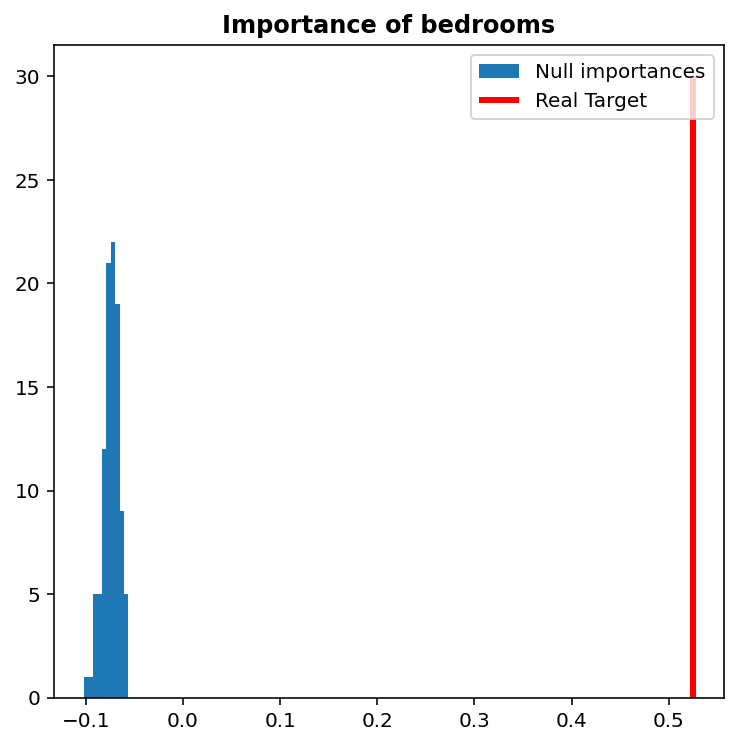

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(imps, label='Null importances')
ax.vlines(baseline_imp, ymin=0, ymax=30, color='r', 
              linewidth=3, label='Real Target')
ax.legend()
ax.set_title(f'Importance of {col}', fontweight='bold');

Again we have p value = 0.0 < 0.05, so we can say *bedrooms* is indeed an important feature.  